In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import gensim.downloader
from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import pickle
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/nlptasks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/nlptasks


In [ ]:
!git clone https://github.com/hrobjarturh/nlptasks.git

fatal: destination path 'nlptasks' already exists and is not an empty directory.


In [ ]:
!git config --global user.email "hallgrimur1998@gmail.com"
!git config --global user.name "hallgrimurth"
!git pull

error: You have not concluded your merge (MERGE_HEAD exists).
hint: Please, commit your changes before merging.
fatal: Exiting because of unfinished merge.


In [ ]:
pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
import math 
import torch

device = torch.device("cpu")
if torch.cuda.is_available():
  pass
  device = torch.device("cuda")
device

device(type='cuda')

In [ ]:
#Load data
dataset = load_dataset("copenlu/answerable_tydiqa")
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 13325
    })
    train: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 116067
    })
})

In [ ]:
#split data 
train_set = dataset["train"]
validation_set = dataset["validation"]

train_set = train_set.to_pandas()
validation_set = validation_set.to_pandas()

In [ ]:
#preprocess data

eng_train_set = train_set[train_set['language'] == 'english']
fin_train_set = train_set[train_set['language'] == 'finnish']
jap_train_set = train_set[train_set['language'] == 'japanese']

eng_validation_set = validation_set[validation_set['language'] == 'english']
fin_validation_set = validation_set[validation_set['language'] == 'finnish']
jap_validation_set = validation_set[validation_set['language'] == 'japanese']
jap_train_set

,question_text,document_title,language,annotations,document_plaintext,document_url
1,“ダン” ダニエル・ジャドソン・キャラハンの出身はどこ,ダニエル・J・キャラハン,japanese,"{'answer_start': [35], 'answer_text': ['カリフォルニ...",“ダン”こと、ダニエル・ジャドソン・キャラハンは1890年7月26日、カリフォルニア州サンフ...,https://ja.wikipedia.org/wiki/%E3%83%80%E3%83%...
17,サー・マイケル・フィリップ・ジャガーの出身は？,ミック・ジャガー,japanese,"{'answer_start': [50], 'answer_text': ['ケント州ダー...",体育教師ジョー・ジャガー(1913〜2006)とエヴァ・ジャガー(1913〜2000)の息子...,https://ja.wikipedia.org/wiki/%E3%83%9F%E3%83%...
45,ラオス王国の王族の名前はなんですか？,ラオス,japanese,"{'answer_start': [122], 'answer_text': ['ラーオ族']}","ラオスの歴史は、中国南西部（現在の雲南省中心）にあった<b data-parsoid='{""...",https://ja.wikipedia.org/wiki/%E3%83%A9%E3%82%...
53,日本テレビ系列『ZIP!』の初代の司会は誰ですか？,ZIP!,japanese,"{'answer_start': [8], 'answer_text': ['桝太一（日本テ...",初代総合司会には桝太一（日本テレビアナウンサー）と関根麻里が起用された[注釈 2]。2人は『...,https://ja.wikipedia.org/wiki/ZIP%21
66,西村眞悟弁護士法違反事件で西村が受けた罰則は何？,西村眞悟弁護士法違反事件,japanese,"{'answer_start': [135], 'answer_text': ['懲役2年・...",その上で「政治資金目当てに依頼者の信頼、ひいては弁護士全体に対する社会的信頼を踏みにじった」...,https://ja.wikipedia.org/wiki/%E8%A5%BF%E6%9D%...
...,...,...,...,...,...,...
116045,日本最大の宗教は何？,日本の宗教,japanese,"{'answer_start': [-1], 'answer_text': ['']}",その後しばらく宗教団体に関する一般法は提案されなかったが[12]、1913年6月、内務省の宗...,https://ja.wikipedia.org/wiki/%E6%97%A5%E6%9C%...
116048,コソボの初代大統領は誰？,コソボの大統領,japanese,"{'answer_start': [-1], 'answer_text': ['']}",コソボ共和国はセルビア人が主導するコソボ・メトヒヤ自治州に対し、アルバニア人が独自の統治を試...,https://ja.wikipedia.org/wiki/%E3%82%B3%E3%82%...
116059,ギュスターヴ・シャルパンティエはいつ生まれた？,ギュスターヴ・シャルパンティエ,japanese,"{'answer_start': [-1], 'answer_text': ['']}",ただし、第一次世界大戦時に負傷兵のための音楽会を主宰し、自作の指揮も行うなど隠棲することはな...,https://ja.wikipedia.org/wiki/%E3%82%AE%E3%83%...
116060,彭 徳懐はいつ生まれた？,彭徳懐故居,japanese,"{'answer_start': [-1], 'answer_text': ['']}",彭徳懐故居（ほうとくかいこきょ）は、中華人民共和国の政治家で軍人（中華人民共和国元帥）だった...,https://ja.wikipedia.org/wiki/%E5%BD%AD%E5%BE%...


In [ ]:
def get_answerability(annotations):
    answerable = []
    for annot in annotations:
        if -1 in annot['answer_start']:
            answerable.append(0)
        else:
            answerable.append(1)
    return answerable


eng_train_set['answerable'] = get_answerability(eng_train_set['annotations'].tolist())
fin_train_set['answerable'] = get_answerability(fin_train_set['annotations'].tolist())
jap_train_set['answerable'] = get_answerability(jap_train_set['annotations'].tolist())

eng_validation_set['answerable'] = get_answerability(eng_validation_set['annotations'].tolist())
fin_validation_set['answerable'] = get_answerability(fin_validation_set['annotations'].tolist())
jap_validation_set['answerable'] = get_answerability(jap_validation_set['annotations'].tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, T5Tokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPT2Model
from transformers import AutoTokenizer
%pip install SentencePiece 

eng_model_checkpoint = 'distilgpt2'
#jap_model_checkpoint = "rinna/japanese-gpt2-medium"
#fin_model_checkpoint = 'Finnish-NLP/gpt2-finnish'

eng_tokenizer = AutoTokenizer.from_pretrained(eng_model_checkpoint)
eng_model = AutoModelForCausalLM.from_pretrained(eng_model_checkpoint)
#model = model.to(device)

#jap_tokenizer = T5Tokenizer.from_pretrained(jap_model_checkpoint)
#jap_tokenizer.do_lower_case = True
#jap_model = AutoModelForCausalLM.from_pretrained(jap_model_checkpoint)


#fin_tokenizer = AutoTokenizer.from_pretrained(fin_model_checkpoint)
#fin_model = AutoModelForCausalLM.from_pretrained(fin_model_checkpoint)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilgpt2/snapshots/c3772e6d13ecdaf8d1105055f7c89becd6e37590/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labe

In [ ]:
def question_parag_combine(questions, paragraphs):
    """
    This function combines the questions and paragraphs into a single text
    Args:
        questions: list of questions
        paragraphs: list of paragraphs
    Returns:
        list of combined questions and paragraphs
    """
    training_data = []
    for index in range(len(questions)):
        training_data += [questions[index] + "\n" + paragraphs[index]]
        
    return training_data

In [ ]:
from datasets import DatasetDict, Dataset

def eng_tokenize_function(examples):
    return eng_tokenizer(examples["text"], truncation=True)

def fin_tokenize_function(examples):
    return fin_tokenizer(examples["text"], truncation=True)

def jap_tokenize_function(examples):
    return jap_tokenizer(examples["text"], truncation=True)

def make_df(train_set, validation_set):
  d_q = train_set['question_text'].tolist()
  d_p = train_set['document_plaintext'].tolist()
  training_data = question_parag_combine(d_q,d_p)
  training_labels = train_set['answerable'].tolist()

  d_q = validation_set['question_text'].tolist()
  d_p = validation_set['document_plaintext'].tolist()
  validation_data = question_parag_combine(d_q,d_p)
  validation_labels = validation_set['answerable'].tolist()



  data_set = {}
  sets = [['train',training_data, training_labels], ['val', validation_data, validation_labels]]
  for meta in sets:
      data_set[meta[0]] = {}
      data_set[meta[0]]['text'] = []
      data_set[meta[0]]['labels'] = []
      
      for ind, text in enumerate(meta[1]):
          data_set[meta[0]]['text'].append(text)
          data_set[meta[0]]['labels'].append(meta[2][ind])

          

          
  data_set = DatasetDict({'train':Dataset.from_dict(data_set['train']),
                          'valid':Dataset.from_dict(data_set['val'])\
                        })
  return data_set

eng_set = make_df(eng_train_set, eng_validation_set)
fin_set = make_df(fin_train_set, fin_validation_set)
jap_set = make_df(jap_train_set, jap_validation_set)

In [ ]:
block_size = 128

def group_texts(examples):
    # Concatenate all texts.
    keys = ['attention_mask', 'input_ids']
    concatenated_examples = {k: sum(examples[k], []) for k in keys}
    total_length = len(concatenated_examples[list(keys)[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    print(total_length)
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    # this is needed as the used dataset is a subclass of ClassificationDataset, which requires label as a field...
    result["label"] = result["input_ids"].copy()
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
def tokenize_set(data_set, tokenize_function):
  tokenized_datasets = data_set.map(tokenize_function, batched=True, batch_size=1000, num_proc=4, remove_columns=["text"])
  tokenized_datasets_lm = tokenized_datasets.map(group_texts, batched=True, batch_size=1000, num_proc=4)
  tokenized_datasets_lm = tokenized_datasets_lm.remove_columns(['label'])
  return tokenized_datasets_lm

lm_eng = tokenize_set(eng_set, eng_tokenize_function)
#lm_fin = tokenize_set(fin_set, fin_tokenize_function)
#lm_jap = tokenize_set(jap_set, jap_tokenize_function)

#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

147968
136960
146688
130816
117376
109952
123520
122880
     

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

37632


#3:   0%|          | 0/1 [00:00<?, ?ba/s]

36992
34048
33024


In [ ]:
lm_eng.save_to_disk('eng_tokenized_dataset')
#lm_jap.save_to_disk('jap_tokenized_dataset')
#lm_fin.save_to_disk('fin_tokenized_dataset')

In [ ]:
#model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    "test-clm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    #max_steps=300
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:

eng_trainer = Trainer(
    model=eng_model,
    args=training_args,
    train_dataset=lm_eng['train'],
    eval_dataset= lm_eng['valid'],
)
'''
fin_trainer = Trainer(
    model=fin_model,
    args=training_args,
    train_dataset=lm_fin['train'],
    eval_dataset= lm_fin['valid'],
)

jap_trainer = Trainer(
    model=jap_model,
    args=training_args,
    train_dataset=lm_jap['train'],
    eval_dataset= lm_jap['valid'],
)
'''

"\nfin_trainer = Trainer(\n    model=fin_model,\n    args=training_args,\n    train_dataset=lm_fin['train'],\n    eval_dataset= lm_fin['valid'],\n)\n\njap_trainer = Trainer(\n    model=jap_model,\n    args=training_args,\n    train_dataset=lm_jap['train'],\n    eval_dataset= lm_jap['valid'],\n)\n"

In [ ]:
eng_eval_results = eng_trainer.evaluate()
#fin_eval_results = fin_trainer.evaluate()
#jap_eval_results = jap_trainer.evaluate()

print(f"Perplexity: {math.exp(eng_eval_results['eval_loss']):.2f}")
#print(f"Perplexity: {math.exp(fin_eval_results['eval_loss']):.2f}")
#print(f"Perplexity: {math.exp(jap_eval_results['eval_loss']):.2f}")
print(eng_eval_results['eval_loss'])

***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8


Perplexity: 48.74
3.8865320682525635


In [ ]:
eng_trainer.train()
#fin_trainer.train()
#jap_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8095
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5060
  Number of trainable parameters = 81912576


Epoch,Training Loss,Validation Loss
1,3.769700,3.618265
2,3.639700,3.608859
3,3.583700,3.607430
4,3.547800,3.608816
5,3.520300,3.610664


Saving model checkpoint to test-clm/checkpoint-500
Configuration saved in test-clm/checkpoint-500/config.json
Model weights saved in test-clm/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test-clm/checkpoint-1000
Configuration saved in test-clm/checkpoint-1000/config.json
Model weights saved in test-clm/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8


Saving model checkpoint to test-clm/checkpoint-1500
Configuration saved in test-clm/checkpoint-1500/config.json
Model weights saved in test-clm/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test-clm/checkpoint-2000
Configuration saved in test-clm/checkpoint-2000/config.json
Model weights saved in test-clm/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to test-clm/checkpoint-2500
Configuration saved in test-clm/checkpoint-2500/config.json
Model weights saved in test-clm/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to test-clm/checkpoint-3000
Configuration saved in test-clm/checkpoint-3000/config.json
Model weights saved in test-clm/checkpoint-3000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8
Saving model checkpoint to test-clm/checkpoint-3500
Configuration saved in test-clm/checkpoint-3500/config.json
Model weights saved in test-clm/chec

TrainOutput(global_step=5060, training_loss=3.619740310488011, metrics={'train_runtime': 1219.7605, 'train_samples_per_second': 33.183, 'train_steps_per_second': 4.148, 'total_flos': 1321998247526400.0, 'train_loss': 3.619740310488011, 'epoch': 5.0})

In [ ]:
eng_eval_results = eng_trainer.evaluate()
#jap_eval_results = jap_trainer.evaluate()
#fin_eval_results = fin_trainer.evaluate()


#print(f"Perplexity: {math.exp(jap_eval_results['eval_loss']):.2f}")
print(f"Perplexity: {math.exp(eng_eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 1107
  Batch size = 8


Perplexity: 36.99


In [ ]:
epoch_eval = np.array([3.8865320682525635, 3.618265, 3.608859, 3.607430, 3.608816, 3.610664])
perplexity = np.exp(epoch_eval)

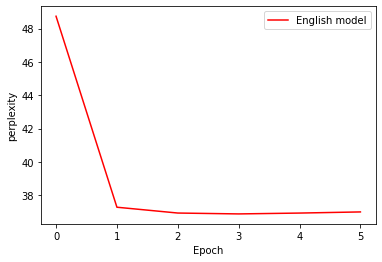

In [ ]:
from matplotlib import pyplot as plt 
#plotting perplexity


plt.ylabel('perplexity')
plt.xlabel('Epoch')
plt.plot(np.arange(6), perplexity, label = 'English model', color = 'r')
plt.legend()
plt.show()

In [ ]:
eng_eval_results['eval_loss']

3.610664129257202

In [ ]:
jap_model = torch.load('drive/MyDrive/jap_model.pth',map_location ='cpu')
fin_model = torch.load('drive/MyDrive/fin_model.pth',map_location ='cpu')
eng_model = torch.load('drive/MyDrive/eng_model.pth',map_location ='cpu')

In [ ]:
torch.save(eng_model, 'eng_model.pth')
#torch.save(jap_model, 'jap_model.pth')

In [ ]:
model = torch.load('models/eng_model_test.pth',map_location ='cpu')

In [ ]:
# Export contextual representations:

def mean_pooling(model_output, attention_mask):
    # Mean Pooling - Take attention mask into account for correct averaging
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.size()).float()
    sum_embeddings = torch.sum(model_output * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


In [ ]:
!ls

drive  fin_model.pth  fin_tokenized_dataset  nlptasks  sample_data  test-clm


In [ ]:
current_language = 'eng'
# import training data
dfte = pd.read_csv('nlptasks/data/dft_eng.csv')
dftj = pd.read_csv('nlptasks/data/dft_jap.csv')
dftf = pd.read_csv('nlptasks/data/dft_fin.csv')


# import validation data
dfve = pd.read_csv('nlptasks/data/dfv_eng.csv')
dfvj = pd.read_csv('nlptasks/data/dfv_jap.csv')
dfvf = pd.read_csv('nlptasks/data/dfv_fin.csv')

In [ ]:
seed = 5555
size_train = 5000
size_valid = 2000

In [ ]:
def split_data(dft, dfv):
  arange_dft = np.arange(len(dft))
  np.random.seed(seed)
  np.random.shuffle(arange_dft)

  dft = dft.iloc[arange_dft]

  train_df = dft.iloc[:size_train]
  valid_df = dft.iloc[size_train:size_train+size_valid]
  test_df = dfv

  train_meta = train_df[['word_frequency_score','logres_pred']].values
  valid_meta = valid_df[['word_frequency_score','logres_pred']].values
  test_meta = test_df[['word_frequency_score','logres_pred']].values

  return train_df, valid_df, test_df, train_meta, valid_meta, test_meta

fin_train_df, fin_valid_df, fin_test_df, fin_train_meta, fin_valid_meta, fin_test_meta = split_data(dftf, dfvf)
eng_train_df, eng_valid_df, eng_test_df, eng_train_meta, eng_valid_meta, eng_test_meta = split_data(dfte, dfve)
jap_train_df, jap_valid_df, jap_test_df, jap_train_meta, jap_valid_meta, jap_test_meta = split_data(dftj, dfvj)

In [ ]:
# use eval to change string list to list get the length of each row

def create_batch(df, meta, model,tokenizer):
  combined = []
  que = df["question_text"].values
  text = df["document_plaintext"].values
  for index in range(len(df)):
    combined.append(str(que[index])+" "+str(text[index]))
  
  last_hidden = []
  for ind,row in enumerate(combined):
    encoded = tokenizer(combined[ind],
                        return_tensors='pt',truncation=True,max_length=64)
    encoded = {k:v.to(device) for k, v in encoded.items()}
    with torch.no_grad():
      model_output = model(**encoded, output_hidden_states=True, return_dict=True)
    pooled_output  = mean_pooling(model_output['hidden_states'][-1], encoded['attention_mask'])
    pooled_output = pooled_output.detach().to(device)


    
    last_hidden.append(pooled_output)

  text_lens = [len(i) for i in combined] # length of all doc lists

  return last_hidden, text_lens, df.label.values, meta
  

In [ ]:
!pwd

/content/drive/MyDrive/nlptasks


In [ ]:
def get_batches(train_df, valid_df, test_df, train_meta, valid_meta, test_meta, model, tokenizer):
  train_dataset = create_batch(train_df, train_meta, model.to(device), tokenizer)
  test_dataset = create_batch(test_df,test_meta, model.to(device), tokenizer) # rest of training for testing
  val_dataset = create_batch(train_df, train_meta, model.to(device), tokenizer)
  return train_dataset, test_dataset, val_dataset



In [ ]:
eng_train, eng_test, eng_val = get_batches(eng_train_df, eng_valid_df, eng_test_df, eng_train_meta, eng_valid_meta, eng_test_meta, eng_model, eng_tokenizer)

#jap_train, jap_test, jap_val = get_batches(jap_train_df, jap_valid_df, jap_test_df, jap_train_meta, jap_valid_meta, jap_test_meta, jap_model, jap_tokenizer)
#fin_train, fin_test, fin_val = get_batches(fin_train_df, fin_valid_df, fin_test_df, fin_train_meta, fin_valid_meta, fin_test_meta, fin_model, fin_tokenizer)

In [ ]:
torch.save(eng_train, 'eng_train_batch')
torch.save(eng_test, 'eng_test_batch')
torch.save(eng_val, 'eng_val_batch')